# Import Modules

In [2]:
!pip install torchview

In [3]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import torch
from torch import nn
from IPython.display import display
import gc
from warnings import filterwarnings
from sklearn.model_selection import StratifiedKFold, train_test_split
import torchview
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import tqdm
from colorama import Fore, Style

gc.collect()

filterwarnings("ignore")

# Config

In [4]:
class Config:
    features_csv = "/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv"
    responders_csv = "/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv"
    train_parqt = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
    test_parqt = "/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet"
    lags_parqt = "/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet"
    sample_csv = "/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv"
    feature_cols = [
        'weight', 'date_id', 'time_id',
        'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
        'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 
        'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 
        'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27',
        'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 
        'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 
        'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 
        'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 
        'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 
        'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 
        'feature_70', 'feature_71', 'feature_72', 'feature_73', 'feature_74', 'feature_75', 'feature_76', 
        'feature_77', 'feature_78',
    ]
    max_len = 60
    train_bs = 16
    val_bs = 32
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 42
    seq_len = 1

# Helper function

In [5]:
def create_folds(df: pd.DataFrame, target_col: str, num_splits: int = 10, bins: int = None) -> pd.DataFrame:
    """

    Helper function to divide a regression dataset into Stratifield folds
    
    """
    df['kfold'] = -1
    skf = StratitiedKFold(num_splits = num_splits)

    if bins is None:
        bins = int(np.ceil(np.log2(N)) + 1) # Stuggs rule

    df['bins'] = pd.cut(df[target_col], bins = bins, labels = False)

    for idx, (train_idx, val_idx) in enumerate(skf.split(X = df, y = df.bins.values)): 
        df['kfold'] = idx

    # Removing the bins col
    df.drop(['bins'], axis = 1, inplace = True)
    return df

def setSeed(seed: int):
    """
    Setting the seed of all the random function to maintain reproducibility

    """
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f'SEEDITIZATION DONE: {seed} !')


setSeed(Config.seed)

SEEDITIZATION DONE: 42 !


# Creating Model

In [6]:
class PositionalEncoding(torch.nn.Module):
    def __init__(
        self,
        d_model: int = 10,
        seq_len: int = 10,
        dropout: float = 0.5
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pos_encoding = torch.zeros(seq_len, d_model)
        positions_list = torch.arange(
            0,
            seq_len,
            dtype = torch.float
        ).view(-1, 1)
        division_term = torch.exp(torch.arange(0, d_model, 2).float()) * -(np.log(1e4/d_model))

        # Prevention: For overshoot values that can result in NAN
        positions_list = torch.clamp(positions_list, min=-1e4, max=1e4)
        division_term = torch.clamp(division_term, min=1e-8, max=1e4)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        pos_encoding = pos_encoding.unsqueeze(0)
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(
        self,
        token_embedding: torch.tensor
    ) -> torch.tensor:
        return self.dropout(
            token_embedding + self.pos_encoding[:token_embedding.size(1), :]
        )


class Model(torch.nn.Module):
    def __init__(
        self, 
        dropout: float = 0.5,
        d_model: int = 64, 
        num_features: int = 82, 
        seq_len: int = Config.seq_len,
        nhead: int = 1, 
        num_encoder_layers: int = 1,
        debug: bool = False
    ):
        super().__init__()
        self.debug = debug
        self.embedding = nn.Linear(num_features, d_model)
        if self.debug: print(self.embedding)
        self.position_encoding = PositionalEncoding(
            d_model = d_model,
            seq_len = seq_len,
            dropout = dropout
        )
        if self.debug: print(self.position_encoding)
        self.transformer_enc_layer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model = d_model,
                nhead = nhead,
                dropout = dropout
            ),
            num_layers = num_encoder_layers,
        )
        if self.debug: print(self.transformer_enc_layer)
        self.output_layer = nn.Linear(d_model, 1)
        if self.debug: print(self.output_layer)

    def forward(self, x) -> torch.tensor:
        # x shape: (bs, seq_len, num_features)
        if self.debug: print("x:", x.shape, x)
        x = self.embedding(x) # (bs, seq_len, d_model)
        if self.debug: print("self.embedding(x): ", x.shape, x)
        x = self.position_encoding(x) # (bs, seq_len, d_model)
        if self.debug: print("self.position_encoding(x): ", x.shape, x)
        x = x.permute(1, 0, 2) # (seq_len, bs, d_model)
        if self.debug: print("x.permute(1, 0, 2): ", x.shape, x)
        x = self.transformer_enc_layer(x) # (seq_len, batch_size, d_model)
        if self.debug: print("self.transformer_enc_layer(x): ", x.shape, x)
        x = x[-1, :, :] # (bs, d_model)
        if self.debug: print("x[-1, :, :]: ", x.shape, x)
        y = self.output_layer(x) # (bs, 1)
        if self.debug: print("y: ", y.shape, y)
        return y

torch.Size([8, 1]) tensor([[-1.1840],
        [-1.1468],
        [-1.2111],
        [-1.2932],
        [-0.9996],
        [-1.1505],
        [-1.2034],
        [-0.8876]], grad_fn=<AddmmBackward0>)


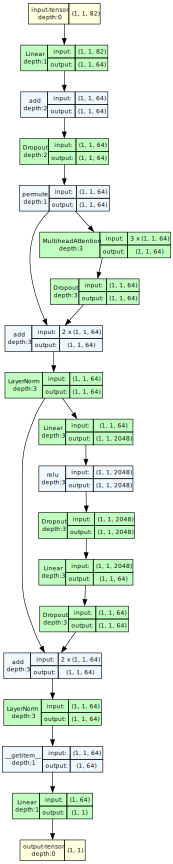

In [7]:
# Visualizing the model
model = Model()
tmp_features = torch.rand((8, Config.seq_len, len(Config.feature_cols)))
model.eval()
tmp_outputs = model(tmp_features)
print(tmp_outputs.shape, tmp_outputs)
model_graph = torchview.draw_graph(model, input_size=(1, Config.seq_len, len(Config.feature_cols)), device=Config.device)
model_graph.visual_graph

In [8]:
# Removing from memory
model = None
del model
gc.collect()

0

In [9]:
df = pd.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet")
df

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,340,0,0,1.902722,-0.523490,-0.131996,0.124154,-0.185518,2.011005,-0.665424,...,-0.183416,0.251685,0.421458,0.771927,0.071990,1.426416,0.814566,-0.132949,1.183992,0.371725
1,340,0,1,4.090041,-0.156282,0.289095,0.193019,-0.070085,1.140459,-0.528798,...,-0.292850,-0.199408,-0.148638,-0.796567,-0.929294,0.055380,-0.585740,-0.891481,0.184394,-0.402399
2,340,0,2,1.403712,-0.002521,-0.261839,-0.006259,0.041238,1.180197,-1.034970,...,2.798186,0.268406,-0.458026,-1.878922,4.185539,0.808422,0.217188,4.563775,0.802501,1.707263
3,340,0,3,0.904068,0.285563,0.159232,0.158522,-0.564407,1.300828,-0.625577,...,-1.028829,0.960588,0.610246,2.921769,-0.170994,1.217213,1.891398,-1.207013,0.868314,0.723984
4,340,0,7,1.308947,0.321869,0.211620,-0.195385,-0.358547,1.595914,-0.820045,...,-0.284915,2.084096,0.359311,0.511679,-0.377202,0.441480,-0.564688,-2.682818,0.118382,-1.588810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036868,509,848,30,2.164852,1.070701,-0.801479,0.977559,1.149705,-0.340906,-0.035956,...,-0.192596,1.448597,0.892907,4.635252,0.226802,0.119362,0.681561,-0.075664,-0.012704,-0.118230
3036869,509,848,33,2.400057,0.942769,-0.566639,1.564250,1.453273,-1.047399,-0.029593,...,-0.324912,-0.031795,-0.675568,0.048584,-0.338851,-0.324938,0.066021,-0.043418,0.013826,-0.057367
3036870,509,848,34,1.031777,1.044136,-1.273992,1.225670,1.330323,-0.475747,-0.029236,...,2.147183,1.331511,0.447017,2.410010,0.936732,0.401676,1.310889,-1.720216,-0.625422,-2.908543
3036871,509,848,36,0.570338,1.214187,-0.600956,1.409845,1.151262,-0.581891,-0.050365,...,-0.200945,1.904021,-0.308449,5.000000,0.320900,0.207751,0.693001,-0.206604,-0.066051,-0.500360


In [10]:
class Pipeline:
    def __init__(
        self,
        data: pd.DataFrame,
        seq_len: int,
        folds: int,
        target_col: str,
        feature_cols: list[str],
        default_value: float = 0.0
    ):
        self.data = data
        self.seq_len = seq_len 
        self.folds = folds 
        self.target_col = target_col 
        self.feature_cols = feature_cols
        self.default_value = default_value
        

        # Taking null count
        print("NULL Count: ", self.data.isnull().sum())
        
        self.labels = self.data[self.target_col].values.tolist()
        self.data = self.data[self.feature_cols]
        
        # Filling nan values with mean
        self.data.fillna(self.data.mean(), inplace = True)

        # IF there are still nan values, filling them up with 0.0
        self.data.fillna(self.default_value, inplace = True)
        
        self.features = self.data.values.tolist()

        # Null check
        print("NULL CHECK: ", self.data.isnull().sum())

    def create_sequences(self):
        """

        Method to create {seq_len} sequences for all the features
        
        """
        features, labels = [], []
        N = len(self.data)
        colored_desc = f"{Fore.GREEN}Making windows{Style.RESET_ALL}"
        with tqdm.tqdm(total = N, desc = colored_desc, unit = "row(s)", ncols = 100) as pbar:
            for end_idx in range(self.seq_len - 1, N):
                # Reversing the values for padding
                start_idx = max(0, end_idx-self.seq_len)
                window_values = self.features[start_idx: end_idx][::-1]
                window_label = self.labels[end_idx]
    
                # Padding windows
                while len(window_values) < self.seq_len: 
                    window_values.append([self.default_value]*len(self.feature_cols))
    
                # Re-Reversing the values for getting padded values
                window_values = window_values[::-1]
    
                features.append(window_values)
                labels.append(window_label)
                pbar.update(1)
                # break

        return features, labels

    def transformation(self):
        """

        Method to apply transformation over the dataset
        
        """
        # 


        # Apply z-transformation over the features
        pass
        
        
    features
    def pipe(self, train_ratio: float = 0.7):
        """

        Method to run the preprocessing pipeline
        
        """
        
        features, labels = self.create_sequences()

        # Diving features and labels into train test split
        split_idx = int(len(features) * 0.7)
        x_train, x_val = features[:split_idx], features[split_idx:]
        y_train, y_val = labels[:split_idx], labels[split_idx:]

        # Converting all data to numpy array as float16
        x_train = np.array(x_train, dtype=np.float16)
        x_val = np.array(x_val, dtype=np.float16)
        y_train = np.array(y_train, dtype=np.float16)
        y_val = np.array(y_val, dtype=np.float16)

        return x_train, x_val, y_train, y_val
    
    def __del__(self):
        self.data = None
        self.seq_len = None 
        self.folds = None 
        self.target_col = None 
        self.feature_cols = None
        gc.collect()

# Sample Dataset

In [11]:
N = int(5e5)
x_train, x_val, y_train, y_val = Pipeline(df.head(N), Config.seq_len, 5, 'responder_6', Config.feature_cols).pipe()
print("x_train.shape: ", x_train.shape)
print("x_val.shape: ", x_val.shape)
print("y_train.shape: ", y_train.shape)
print("y_val.shape: ", y_val.shape)

NULL Count:  date_id        0
time_id        0
symbol_id      0
weight         0
feature_00     0
              ..
responder_4    0
responder_5    0
responder_6    0
responder_7    0
responder_8    0
Length: 92, dtype: int64
NULL CHECK:  weight        0
date_id       0
time_id       0
feature_00    0
feature_01    0
             ..
feature_74    0
feature_75    0
feature_76    0
feature_77    0
feature_78    0
Length: 82, dtype: int64


Making windows: 100%|███████████████████████████████| 500000/500000 [00:02<00:00, 177376.73row(s)/s]


x_train.shape:  (350000, 1, 82)
x_val.shape:  (150000, 1, 82)
y_train.shape:  (350000,)
y_val.shape:  (150000,)


# DataLoaders

In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.float32)

    def __len__(self) -> int: return len(self.features)

    def __getitem__(self, idx: int) -> tuple[torch.tensor, torch.tensor]:
        return self.features[idx].to(Config.device), self.labels[idx].to(Config.device)

In [13]:
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size = Config.train_bs)
val_loader = DataLoader(val_dataset, batch_size = Config.val_bs)

# Callbacks && metrics

In [15]:
class PlottingCallback():
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_r2_scores = []
        self.val_r2_scores = []
        self.epoch = -1

    def update(
        self, 
        train_loss, 
        val_loss, 
        y_train_true, 
        y_train_pred, 
        train_weights,
        y_val_true, 
        y_val_pred,
        val_weights,
        epoch
    ):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)

        train_r2 = w_r2_score(y_train_true, y_train_pred, train_weights)
        val_r2 = w_r2_score(y_val_true, y_val_pred, val_weights)

        self.train_r2_scores.append(train_r2)
        self.val_r2_scores.append(val_r2)

        self.epoch = epoch

        self.plot_metrics()

    def plot_metrics(self):
        """

        Method to plot the metrics
        
        """
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize = (15, 7))
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Train Loss", marker="o")
        plt.plot(epochs, self.val_losses, label="Validation Loss", marker="o")
        plt.title("Loss per Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # R2_score plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_r2_scores, label="Train Weighted R²", marker="o")
        plt.plot(epochs, self.val_r2_scores, label="Validation Weighted R²", marker="o")
        plt.title("Weighted R² Score per Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Weighted R² Score")
        plt.legend()

        # Show plots
        plt.tight_layout()
        plt.savefig(f"training_metrics_{self.epoch}.png")
        plt.close()  # Clears the figure to save memory

def w_r2_score(y_true, y_pred, weights):
    """

    Function to compute weighted r2 score
    
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    weights = np.array(weights)

    numerator = np.sum(weights * (y_true - y_pred)**2)
    denominator = np.sum(weights * y_true**2)
    return 1 - (numerator/denominator)

class WeightedMSELoss(nn.Module):
    def __init__(self): 
        super().__init__()
        
    def forward(self, y_pred, y_true, weights):
        # print(y_pred.shape, y_true.shape, weights.shape)
        y_pred = y_pred.squeeze()
        y_true = y_true.squeeze()

        numerator = torch.sum(weights * torch.abs(y_true - y_pred))
        denominator = torch.sum(weights)
        return numerator/denominator

# Training

In [16]:
plotting_callback = PlottingCallback()
model = Model()
model.to(Config.device)

loss_fn = WeightedMSELoss()
lr = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

num_epochs = 3
for epoch in range(num_epochs):
    # Training
    model.train()

    train_loss = 0
    y_train_true, y_train_pred, train_r2_scores = [], [], []
    with tqdm.tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs} [Training]", ncols=100) as pbar:
        for features, labels in train_loader:
            features = features.to(Config.device)
            labels = labels.to(Config.device)
            # per batch taking the last weight value corresponding to the y_label
            weights = features[:, -1, 0]
            
            outputs = model(features)
            # print(outputs)
            loss = loss_fn(outputs, labels, weights)
            train_loss += loss.item()
    
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            y_train_true.extend(labels.detach().cpu().numpy())
            y_train_pred.extend(outputs.detach().cpu().numpy())

            train_r2_score = w_r2_score(
                    labels.cpu().numpy(),
                    outputs.detach().cpu().numpy(),
                    weights.cpu().numpy()
                )
            train_r2_scores.append(train_r2_score)
    
            # Updating the progress bar
            pbar.set_postfix(loss = loss.item(), train_r2_score = train_r2_score)
            pbar.update(1)

    # Validation
    val_loss = 0
    y_val_true, y_val_pred, val_r2_scores = [], [], []
    model.eval()

    with tqdm.tqdm(total=len(val_loader), desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]", ncols=100) as pbar:
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(Config.device)
                labels = labels.to(Config.device)
                # per batch taking the last weight value corresponding to the y_label
                weights = features[:, -1, 0]
                
                outputs = model(features)
                loss = loss_fn(outputs, labels, weights)
                val_loss += loss.item()
        
                y_val_true.extend(labels.detach().cpu().numpy())
                y_val_pred.extend(outputs.detach().cpu().numpy())

                val_r2_score = w_r2_score(
                    labels.cpu().numpy(),
                    outputs.detach().cpu().numpy(),
                    weights.cpu().numpy()
                )
                val_r2_scores.append(val_r2_score)
                    
                # Updating the progress bar
                pbar.set_postfix(loss = loss.item(), val_r2_score = val_r2_score)
                pbar.update(1)

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # plotting_callback.update(
    #     train_loss,
    #     val_loss,
    #     y_train_true,
    #     y_train_pred,
    #     train_weights,
    #     y_val_true,
    #     y_val_pred,
    #     val_weights,
    #     epoch
    # )

    avg_train_r2 = sum(train_r2_scores) / len(train_r2_scores)
    avg_val_r2 = sum(val_r2_scores) / len(val_r2_scores)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, train_r2: {avg_train_r2:.4f}, val_r2: {avg_val_r2:.4f}")

Epoch 1/3 [Training]:   6%|▏  | 1395/21875 [00:12<03:04, 111.16it/s, loss=0.3, train_r2_score=-15.3]


KeyboardInterrupt: 

In [ ]:
checkpoint_path = "transfomer.pth"

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'avg_train_r2': avg_train_r2,
    'avg_val_r2': avg_val_r2
}, checkpoint_path)

print(f"Model and optimizer states saved to {checkpoint_path}")

In [ ]:
avg_val_r2 = sum(val_r2_scores) / len(val_r2_scores)
avg_val_r2